In [1]:
%matplotlib widget

In [2]:
# Imports
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats 
from numpy.lib.stride_tricks import sliding_window_view

import utils
import config

In [3]:
# Open data files
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)

# Load data
data=utils.load_data(fname)


In [4]:
#dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
#dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']

## Explore one dataset

In [5]:
mice=11

In [9]:
dataset = data[mice]
print(dataset.keys())
print(" ")
print(dat_ST[mice].keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])
 
dict_keys(['ss', 'ss_passive'])


In [10]:
np.unique(dataset['brain_area'])

array(['ACA', 'CA1', 'DG', 'LGd', 'LH', 'MD', 'MOs', 'PL', 'SUB', 'VISam',
       'VISp', 'root'], dtype='<U5')

### Brain areas

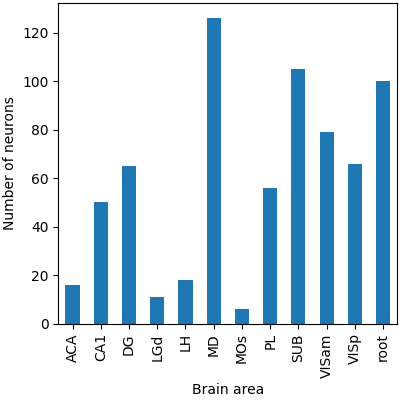

In [11]:
fig, ax = plt.subplots()
unique, counts = np.unique(dataset['brain_area'], return_counts=True)
pd.DataFrame.from_dict(dict(zip(unique, counts)),orient='index').plot(kind='bar',figsize=(4, 4),legend=False,ax=ax)
ax.set(xlabel='Brain area', ylabel='Number of neurons')
fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

### Events

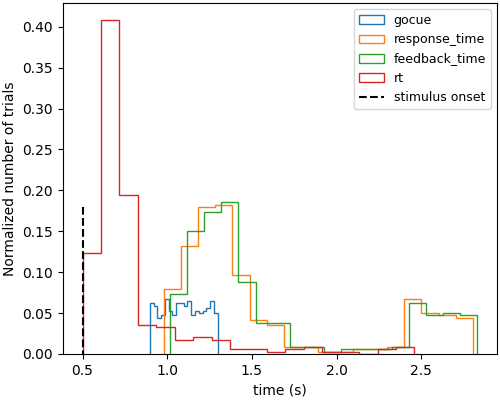

stimulus onset: 0.5
reaction_time mean: 0.79
gocue mean: 1.10
response_time mean: 1.59
feedback_time mean: 1.62


In [12]:
fig, ax = plt.subplots(figsize=(5, 4))
#unique, counts = np.unique(dataset['gocue'], return_counts=True)
weights = np.ones_like(dataset['gocue'])/float(len(dataset['gocue']))
ax.hist(dataset['gocue']+0.5,weights=weights,histtype="step",bins=int(np.sqrt(len(dataset['feedback_time']))))
weights = np.ones_like(dataset['response_time'])/float(len(dataset['response_time']))
ax.hist(dataset['response_time']+0.5,bins=int(np.sqrt(len(dataset['feedback_time']))),histtype="step",weights=weights)
weights = np.ones_like(dataset['feedback_time'])/float(len(dataset['feedback_time']))
ax.hist(dataset['feedback_time']+0.5,bins=int(np.sqrt(len(dataset['feedback_time']))),histtype="step",weights=weights)

weights = np.ones_like(dataset['reaction_time'][:,0])/float(len(dataset['reaction_time'][:,0]))
ax.hist(np.where(dataset['reaction_time'][:,0]==np.inf,np.nan,dataset['reaction_time'][:,0]/1000)+0.5,bins=int(np.sqrt(len(dataset['reaction_time'][:,0]))),histtype="step",weights=weights)

ax.vlines(0.5,0.18,0,color="k",linestyles="--")

ax.set(xlabel='time (s)', ylabel='Normalized number of trials')
plt.legend(['gocue', 'response_time','feedback_time',"rt", 'stimulus onset'], fontsize=9)
fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

print("stimulus onset: 0.5")# stimulus onset 0.5
print("reaction_time mean: %0.2f"%(np.nanmean(np.where(dataset['reaction_time'][:,0]==np.inf,np.nan,dataset['reaction_time'][:,0]/1000))+0.5))# reaction time
print("gocue mean: %0.2f"%(dataset['gocue'].mean()+0.5))# go cue 1.1
print("response_time mean: %0.2f"%(dataset['response_time'].mean()+0.5))# response 1.54
print("feedback_time mean: %0.2f"%(dataset['feedback_time'].mean()+0.5))# feedback

### Raster plot

Mouse name:  Lederberg


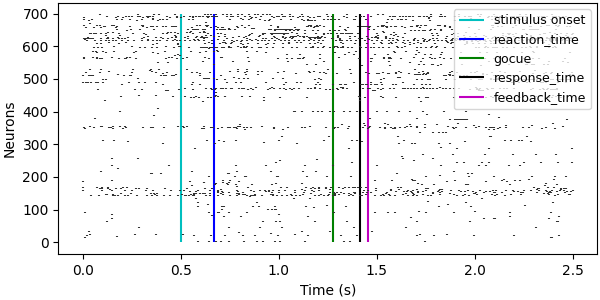

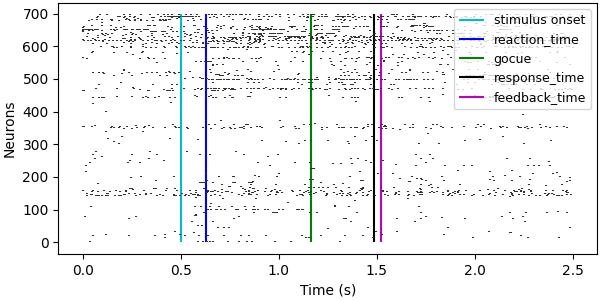

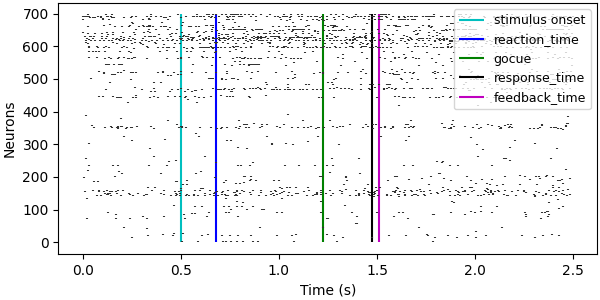

In [13]:
dataset_ST = dat_ST[mice]

print("Mouse name: ",dataset['mouse_name'])
vis_right = dataset['contrast_right']  # 0 - low - high
vis_left = dataset['contrast_left'] 

idx = np.where(np.logical_and(vis_left == 0, vis_right > 0))[0] 
trial_dat_raster_ST=dataset_ST['ss'][:,idx]

for i_trial in range(0,3):#trial_dat_raster_ST.shape[1]
  a=utils.plot_raster(dataset,trial_dat_raster_ST,i_trial=i_trial,idx=idx)
  

### Compute latencies

In [14]:
n_neurons = dataset_ST['ss'].shape[0]
n_trials = dataset_ST['ss'].shape[1]
n_times = 2501
data_1ms = np.zeros((n_neurons,n_trials,n_times), dtype=np.int64)

In [34]:
# spikes during trials
for i_trial in range(n_trials): # define matrix with number of spike each ms
    for i_neuron in range(n_neurons):

        idx_spike = np.rint(dataset_ST['ss'][i_neuron][i_trial]*1000).astype(int)
        if len(idx_spike)-len(np.unique(idx_spike)) !=0: # more than one spike each ms
            for idx_s in idx_spike:
                data_1ms[i_neuron,i_trial,idx_s] = data_1ms[i_neuron,i_trial,idx_s] + 1 
        else: # only one spike each ms   
            data_1ms[i_neuron,i_trial,idx_spike]=1


In [35]:
dataset['spks_passive'].shape

(698, 110, 250)

In [36]:
# passive spikes
passive_dat_raster_ST = dat_ST[mice]['ss_passive']
passive_data_1ms = np.zeros((n_neurons,n_trials,n_times), dtype=np.int64)

n_trials= passive_dat_raster_ST.shape[1]

for i_trial in range(n_trials): # define matrix with number of spike each ms
    for i_neuron in range(n_neurons):

        idx_spike = np.rint(passive_dat_raster_ST[i_neuron][i_trial]*1000).astype(int)
        if len(idx_spike)-len(np.unique(idx_spike)) !=0: # more than one spike each ms
            for idx_s in idx_spike:
                passive_data_1ms[i_neuron,i_trial,idx_s] = passive_data_1ms[i_neuron,i_trial,idx_s] + 1 
        else: # only one spike each ms   
            passive_data_1ms[i_neuron,i_trial,idx_spike] = 1

In [37]:
vis_right = dataset['contrast_right'] 
vis_left = dataset['contrast_left'] 

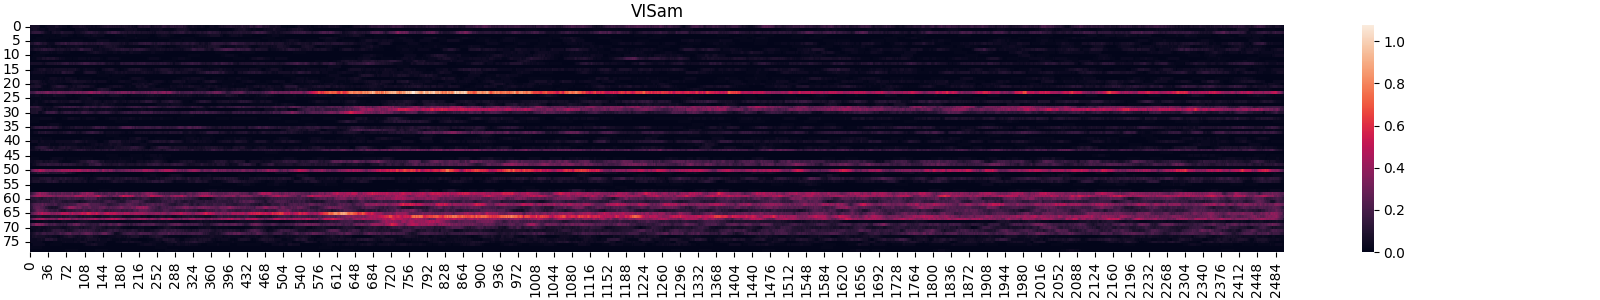

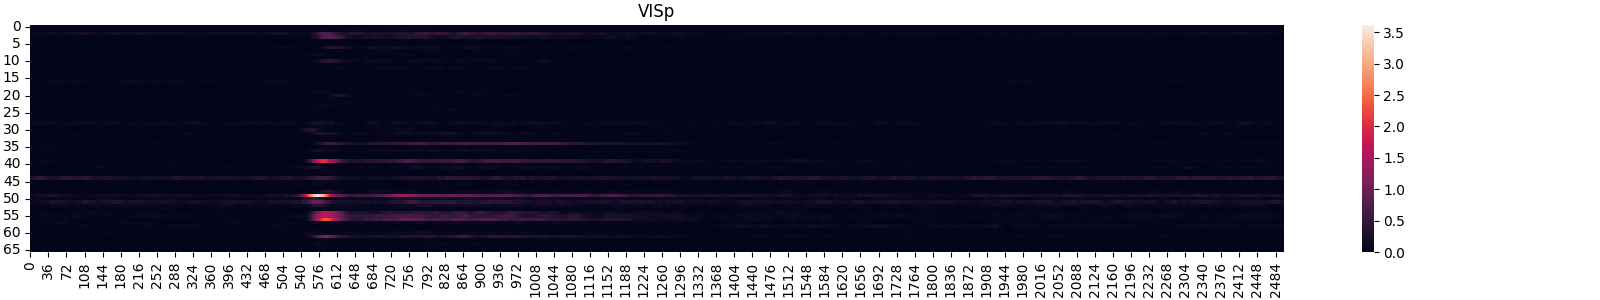

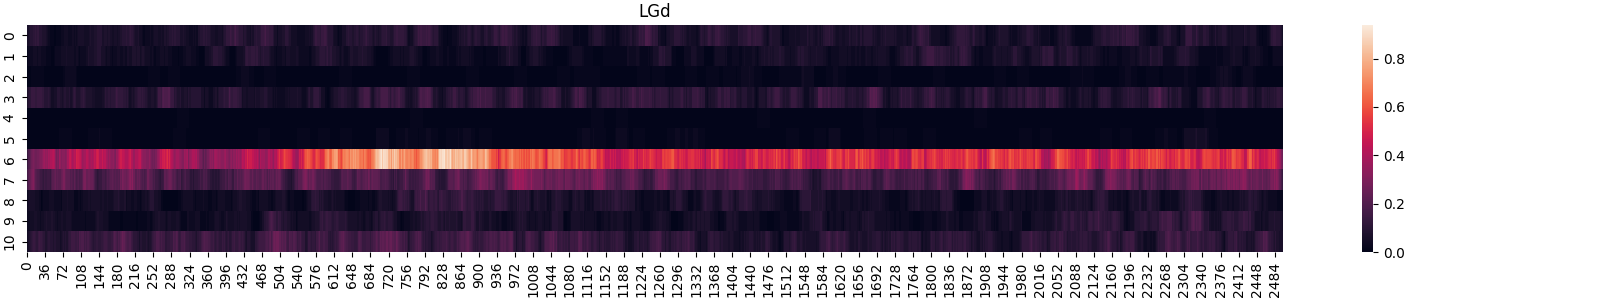

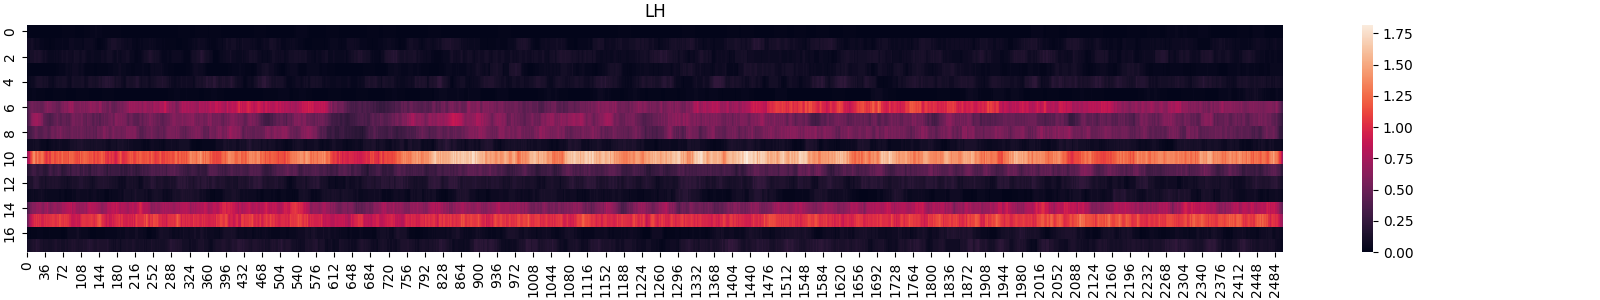

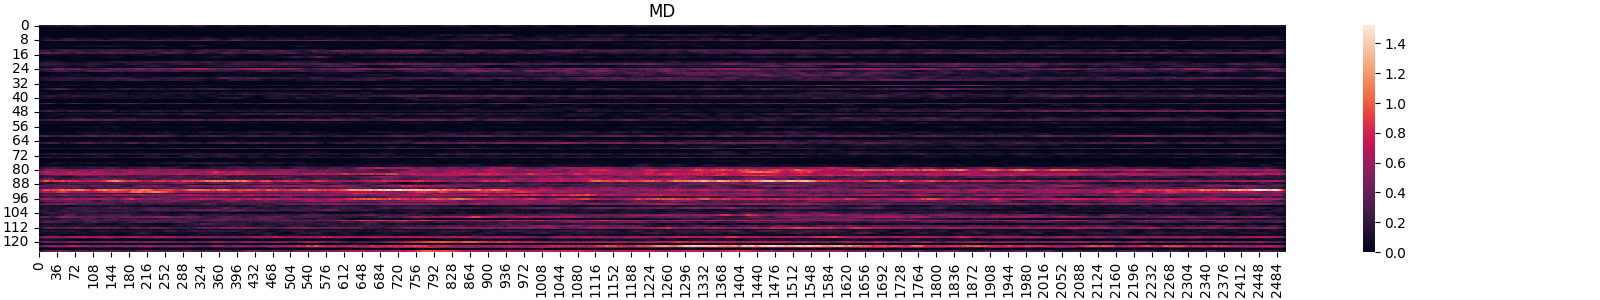

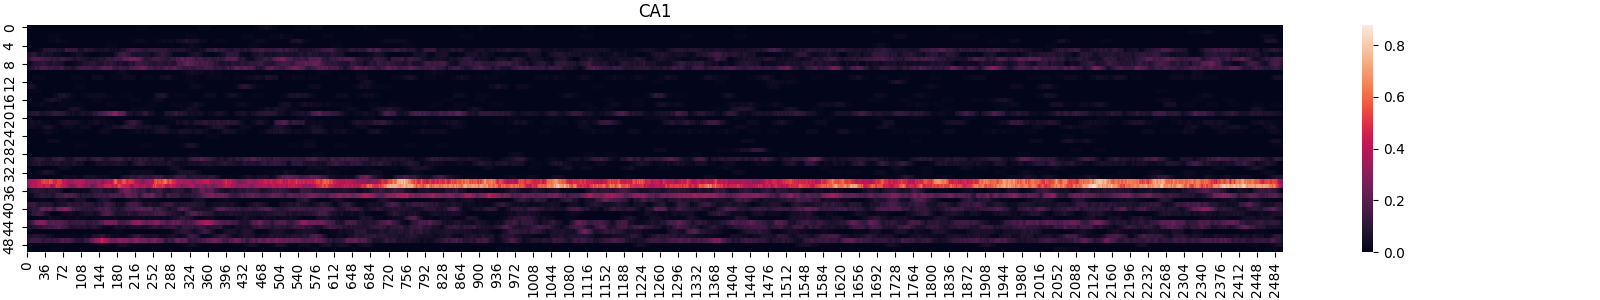

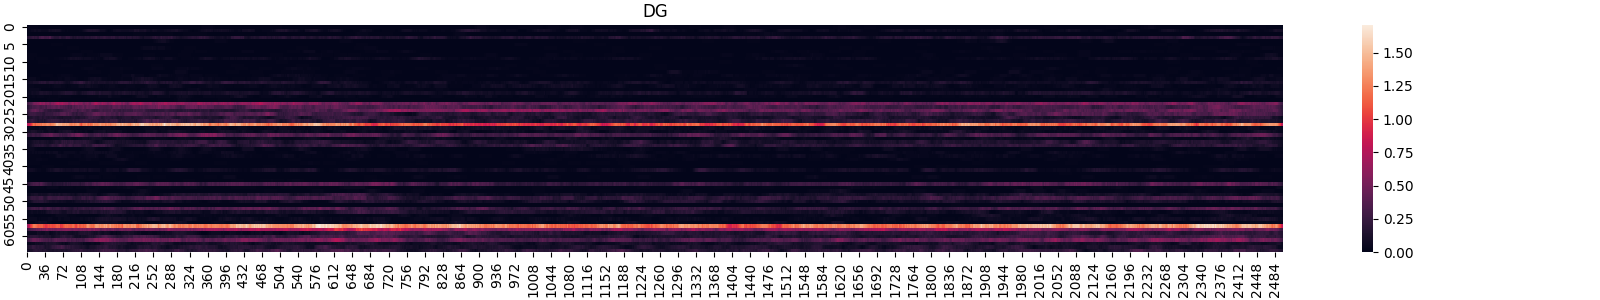

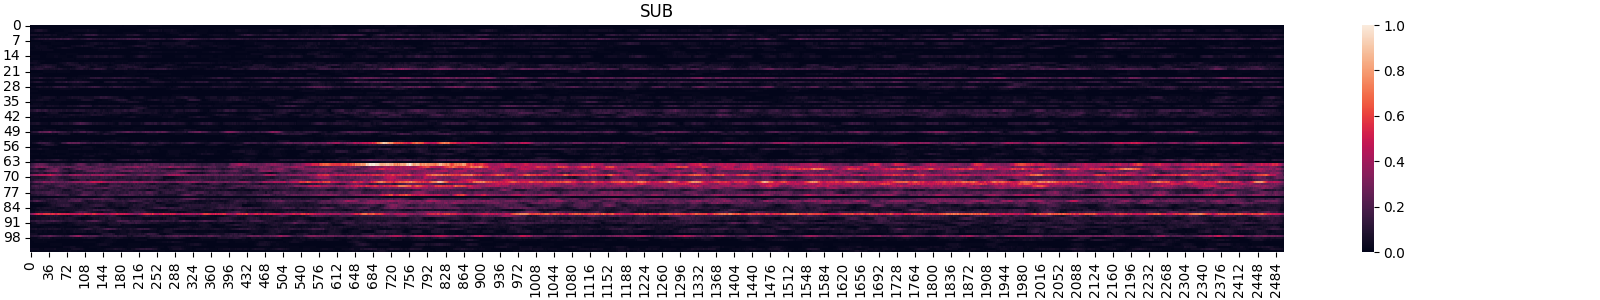

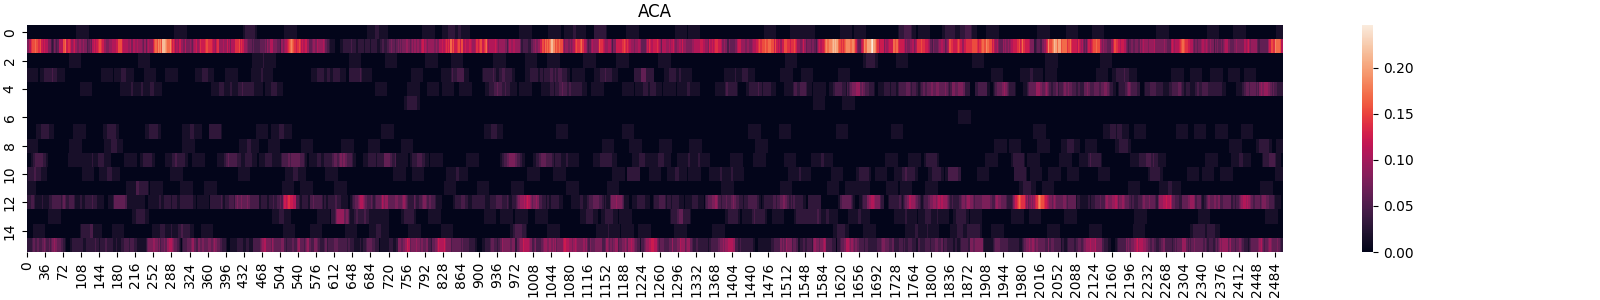

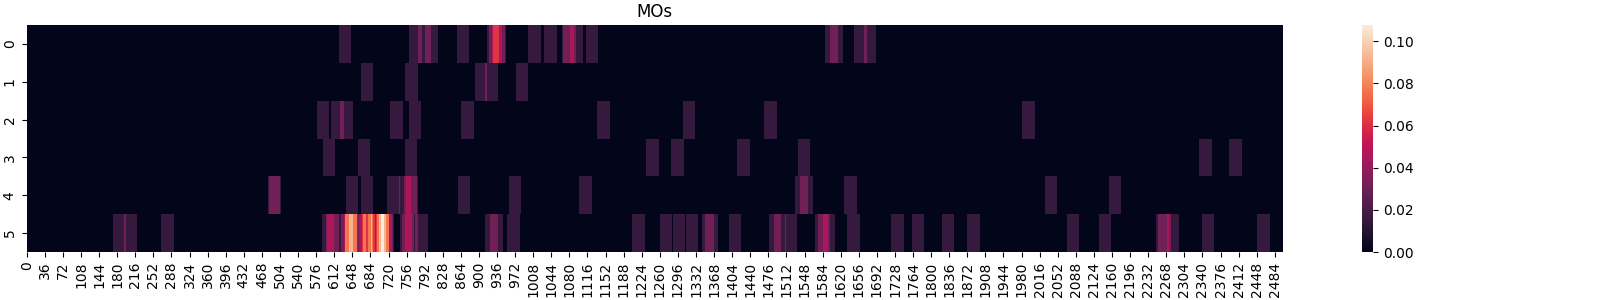

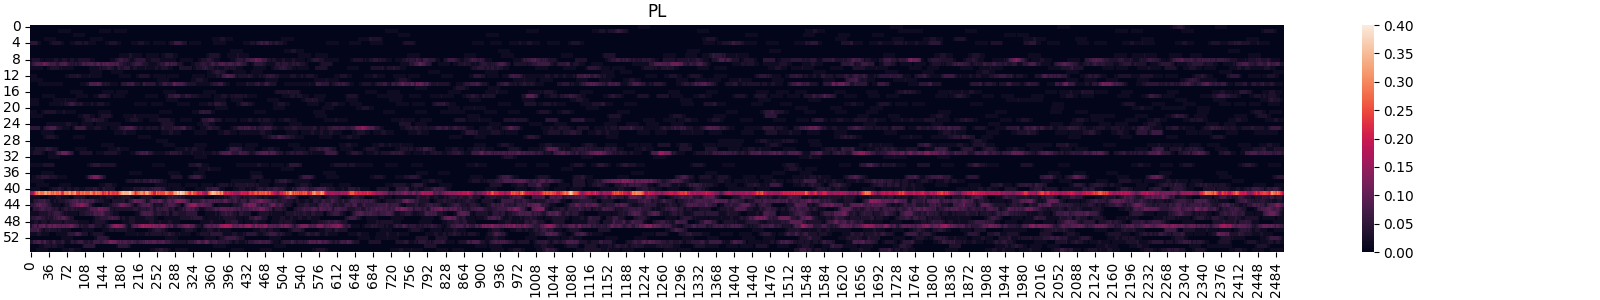

In [58]:
idx_trials = np.where(np.logical_and(vis_left == 0, vis_right > 0))[0]


for i_bregion in range(len(config.BRAIN_GROUPS)):
    for group in range(len(config.BRAIN_GROUPS[i_bregion])):
        idx=np.where(np.isin(dataset['brain_area'], config.BRAIN_GROUPS[i_bregion][group]))[0]
        load=data_1ms[idx][:,idx_trials,:].mean(axis=1)

        for i_neuron in range(load.shape[0]):
            load[i_neuron] = np.convolve(load[i_neuron],np.ones(25,dtype=int),'same')
    
        if load.shape[0] !=0:
            fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,3))
            sns.heatmap(load, vmin=0,ax=ax)#[:,::2]
            ax.set_title(config.BRAIN_GROUPS[i_bregion][group])
            fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
            plt.show()

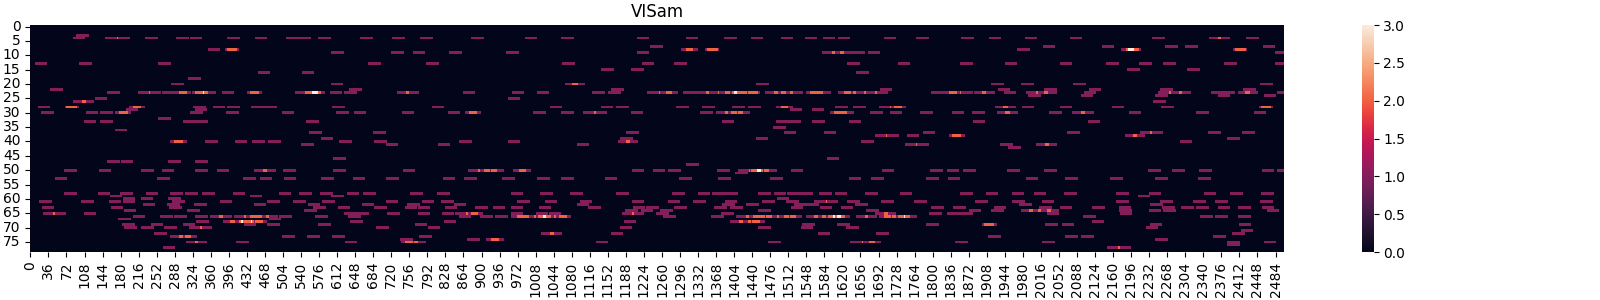

In [49]:
for group in range(len(config.BRAIN_GROUPS[b_region])-4):
    idx=np.where(np.isin(dataset['brain_area'], config.BRAIN_GROUPS[b_region][group]))[0]
    load_1=passive_data_1ms[idx,0]#.mean(axis=1)

    for i_neuron in range(load_1.shape[0]):
        load_1[i_neuron] = np.convolve(load_1[i_neuron],np.ones(25,dtype=int),'same')
    if load_1.shape[0] !=0:
        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,3))
        sns.heatmap(load_1, vmin=0,ax=ax)#[:,::2]
        ax.set_title(config.BRAIN_GROUPS[b_region][group])
        fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
        plt.show()

In [46]:

pp_all=[]
for i_neuron in range(load.shape[0]):
    pp=[]
    for i_window in sliding_window_view(load[i_neuron,:], window_shape = 25):
        
        pp.append(stats.wilcoxon(i_window, load_1[i_neuron,25:50]       ,zero_method ='zsplit')[1])#sliding_window_view(load_1[i_neuron,:], window_shape = 25).mean(axis=0)
    pp_all.append(pp)

C:\Users\camil\AppData\Local\Temp\ipykernel_11032\881291132.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,3))


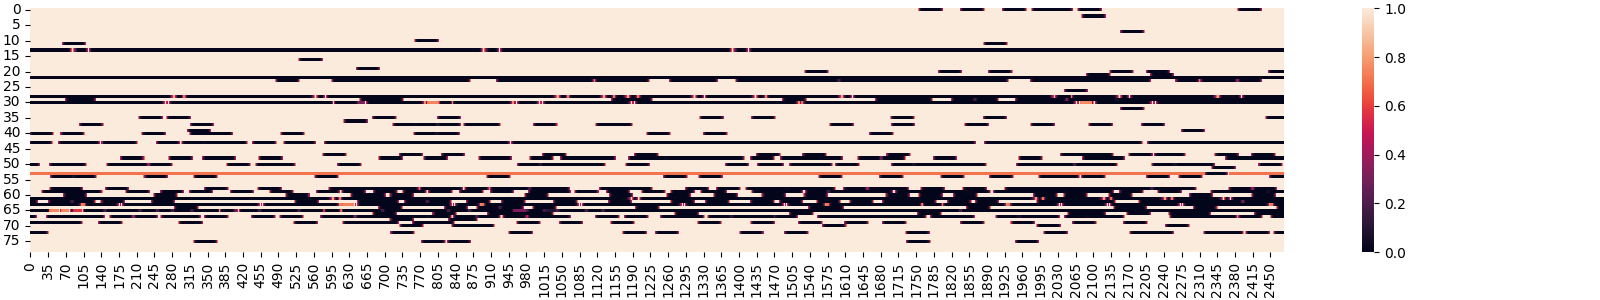

In [47]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,3))
sns.heatmap(pp_all, vmin=0,ax=ax)

fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

In [ ]:
plt.close('all')

# Explore all datasets

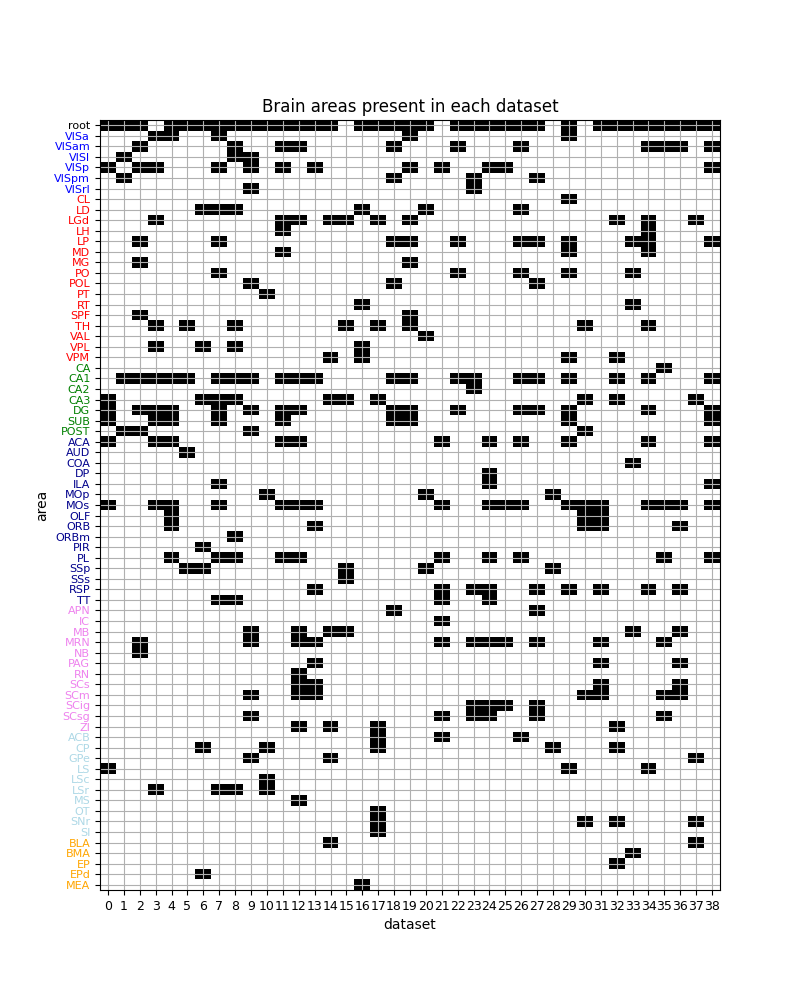

In [16]:
# Make a plot of which brain areas are present in each dataset

# Assign each area an index (region 4 does not correspond to brain_group 4)
area_to_index = dict(root=0)
counter = 1
for group in config.BRAIN_GROUPS:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(data)), dtype=bool)
for j, d in enumerate(data):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in config.BRAIN_GROUPS:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(data)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(config.BRAIN_GROUPS, config.REGION_COLORS):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

In [17]:
for i in range(39):
    print("Mouse %d name: %s"%(i,data[i]['mouse_name']))

Mouse 0 name: Cori
Mouse 1 name: Cori
Mouse 2 name: Cori
Mouse 3 name: Forssmann
Mouse 4 name: Forssmann
Mouse 5 name: Forssmann
Mouse 6 name: Forssmann
Mouse 7 name: Hench
Mouse 8 name: Hench
Mouse 9 name: Hench
Mouse 10 name: Hench
Mouse 11 name: Lederberg
Mouse 12 name: Lederberg
Mouse 13 name: Lederberg
Mouse 14 name: Lederberg
Mouse 15 name: Lederberg
Mouse 16 name: Lederberg
Mouse 17 name: Lederberg
Mouse 18 name: Moniz
Mouse 19 name: Moniz
Mouse 20 name: Moniz
Mouse 21 name: Muller
Mouse 22 name: Muller
Mouse 23 name: Muller
Mouse 24 name: Radnitz
Mouse 25 name: Radnitz
Mouse 26 name: Radnitz
Mouse 27 name: Radnitz
Mouse 28 name: Radnitz
Mouse 29 name: Richards
Mouse 30 name: Richards
Mouse 31 name: Richards
Mouse 32 name: Richards
Mouse 33 name: Richards
Mouse 34 name: Tatum
Mouse 35 name: Tatum
Mouse 36 name: Tatum
Mouse 37 name: Tatum
Mouse 38 name: Theiler


In [18]:
dataset['spks'].shape # number of neurons by number of trials by time bins of 10 ms

(698, 340, 250)

In [19]:
dat_9 = data[9]
np.unique(dat_9['brain_area'])

array(['CA1', 'DG', 'GPe', 'MB', 'MRN', 'POL', 'POST', 'SCm', 'SCsg',
       'VISl', 'VISp', 'VISrl', 'root'], dtype='<U5')

In [20]:
response_9 = dat_9['response']  # right - nogo - left (-1, 0, 1)
vis_right_9 = dat_9['contrast_right']  # 0 - low - high
vis_left_9 = dat_9['contrast_left']  # 0 - low - high
data_9_VISl = dat_9['spks'][dat_9['brain_area']=='VISl'][:, np.logical_and(vis_left_9 == 0, vis_right_9 > 0,response_9 ==-1)].reshape(-1,250) # stimulus on the right, response right (correct responses)
data_9_VISp = dat_9['spks'][dat_9['brain_area']=='VISp'][:, np.logical_and(vis_left_9 == 0, vis_right_9 > 0,response_9 ==-1)].reshape(-1,250)
data_9_VISrl = dat_9['spks'][dat_9['brain_area']=='VISrl'][:, np.logical_and(vis_left_9 == 0, vis_right_9 > 0,response_9 ==-1)].reshape(-1,250)

In [21]:
dat_8 = data[8]
np.unique(dat_8['brain_area'])

array(['CA1', 'CA3', 'LD', 'LSr', 'ORBm', 'PL', 'TH', 'TT', 'VISam',
       'VISl', 'VPL', 'root'], dtype='<U5')

In [22]:
response_8 = dat_8['response']  # right - nogo - left (-1, 0, 1)
vis_right_8 = dat_8['contrast_right']  # 0 - low - high
vis_left_8 = dat_8['contrast_left']  # 0 - low - high
data_8_VISam = dat_8['spks'][dat_8['brain_area']=='VISam'][:, np.logical_and(vis_left_8 == 0, vis_right_8 > 0,response_8 ==-1)].reshape(-1,250) # stimulus on the right, response right (correct responses)
data_8_VISl = dat_8['spks'][dat_8['brain_area']=='VISl'][:, np.logical_and(vis_left_8 == 0, vis_right_8 > 0,response_8 ==-1)].reshape(-1,250)

In [23]:
dat_7 = data[7]
np.unique(dat_7['brain_area'])

array(['CA1', 'CA3', 'DG', 'ILA', 'LD', 'LP', 'LSr', 'MOs', 'PL', 'PO',
       'SUB', 'TT', 'VISa', 'VISp', 'root'], dtype='<U4')

In [24]:
response_7 = dat_7['response']  # right - nogo - left (-1, 0, 1)
vis_right_7 = dat_7['contrast_right']  # 0 - low - high
vis_left_7 = dat_7['contrast_left']  # 0 - low - high
data_7_VISa = dat_7['spks'][dat_7['brain_area']=='VISa'][:, np.logical_and(vis_left_7 == 0, vis_right_7 > 0,response_7 ==-1)].reshape(-1,250) # stimulus on the right, response right (correct responses)
data_7_VISp = dat_7['spks'][dat_7['brain_area']=='VISp'][:, np.logical_and(vis_left_7 == 0, vis_right_7 > 0,response_7 ==-1)].reshape(-1,250)

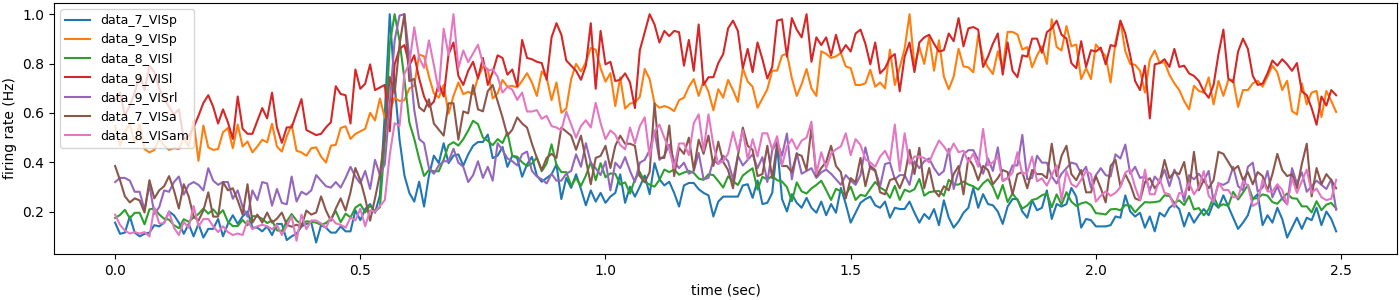

In [27]:
fig,ax = plt.subplots(figsize=(14, 3))
dt = dataset['bin_size']  # binning at 10 ms
NT = dataset['spks'].shape[-1]
plt.plot(dt * np.arange(NT), data_7_VISp.mean(axis=0)/max(data_7_VISp.mean(axis=0))) 
plt.plot(dt * np.arange(NT), data_9_VISp.mean(axis=0)/max(data_9_VISp.mean(axis=0)))

plt.plot(dt * np.arange(NT), data_8_VISl.mean(axis=0)/max(data_8_VISl.mean(axis=0))) 
plt.plot(dt * np.arange(NT), data_9_VISl.mean(axis=0)/max(data_9_VISl.mean(axis=0)))

plt.plot(dt * np.arange(NT), data_9_VISrl.mean(axis=0)/max(data_9_VISrl.mean(axis=0)))

plt.plot(dt * np.arange(NT), data_7_VISa.mean(axis=0)/max(data_7_VISa.mean(axis=0)))  

plt.plot(dt * np.arange(NT), data_8_VISam.mean(axis=0)/max(data_8_VISam.mean(axis=0)))  


plt.legend(['data_7_VISp', 'data_9_VISp','data_8_VISl','data_9_VISl','data_9_VISrl','data_7_VISa',  'data_8_VISam'], fontsize=9)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


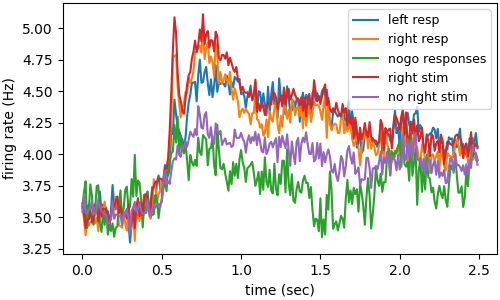

In [28]:
# select just one of the recordings here. 9 is nice because it has neurons in vis ctx.

print(dataset.keys())

dt = dataset['bin_size']  # binning at 10 ms
NT = dataset['spks'].shape[-1]

fig,ax = plt.subplots(figsize=(5, 3))
response = dataset['response']  # right - nogo - left (-1, 0, 1)
vis_right = dataset['contrast_right']  # 0 - low - high
vis_left = dataset['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dataset['spks'][:, response > 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dataset['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dataset['spks'][:, response == 0].mean(axis=(0, 1)))  # nogo responses

plt.plot(dt * np.arange(NT), 1/dt * dataset['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dataset['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp','nogo responses', 'right stim', 'no right stim'], fontsize=9)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

In [29]:
dataset['spks_passive'][0,:,:].shape

(110, 250)

In [30]:
np.unique(dataset['brain_area'])

array(['ACA', 'CA1', 'DG', 'LGd', 'LH', 'MD', 'MOs', 'PL', 'SUB', 'VISam',
       'VISp', 'root'], dtype='<U5')

In [31]:
nareas = 3  # only the top 4 regions are in this particular mouse
NN = len(dataset['brain_area'])  # number of neurons
barea = -1 * np.ones(NN, )  # -1 is "other"
for j in range(nareas):
  barea[np.isin(dataset['brain_area'], config.BRAIN_GROUPS[j])] = j  # assign a number to each region

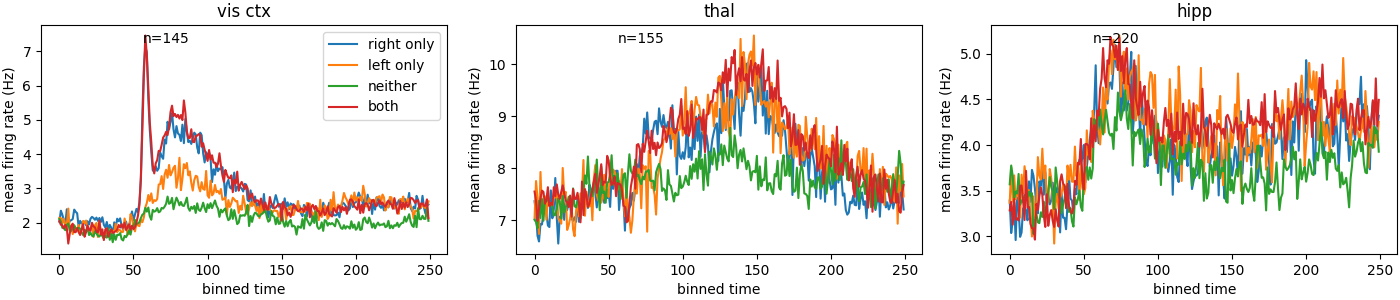

In [32]:
fig,ax = plt.subplots(nrows=1, ncols=nareas,figsize=(14,3))
for j in range(nareas):
  

  ax[j].plot(1/dt * dataset['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dataset['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dataset['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dataset['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  ax[j].text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax[j].transAxes)
  if j==0:
    ax[j].legend(['right only', 'left only', 'neither', 'both'], fontsize=10)
  ax[j].set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=config.REGIONS[j])

fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

In [33]:
(1/dt * dataset['spks'][barea==0][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1))).shape

(250,)

### Perform PCA

In [ ]:
i_start = 0
i_end = 170
dat_right_left = np.reshape(dataset['spks'][:, :, i_start:i_end], (NN, -1)) # from 100 ms before stimulus to s after stimulus   
print(dat_right_left.shape)
dat_right_left_z = utils.z_score(dat_right_left)#dat_right_left - np.mean(dat_right_left, axis=1)[:, np.newaxis]
model = PCA(n_components=5).fit(dat_right_left_z.T)
W = model.components_
pc_10ms = W @ np.reshape(dataset['spks'], (NN, -1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))
pc_10ms.shape

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(pc_10ms), figsize=(14,3))
fig_2, ax_2 = plt.subplots(nrows=1, ncols=len(pc_10ms), figsize=(14,3))

for j in range(len(pc_10ms)):
  
  pc1 = pc_10ms[j]

  ax[j].plot(pc1[np.logical_and(vis_left == 0, vis_right > 0), :].mean(axis=0))
  ax[j].plot(pc1[np.logical_and(vis_left > 0, vis_right == 0), :].mean(axis=0))
  ax[j].plot(pc1[np.logical_and(vis_left == 0, vis_right == 0), :].mean(axis=0))
  ax[j].plot(pc1[np.logical_and(vis_left > 0, vis_right > 0), :].mean(axis=0))

  if j == 0:
    ax[j].legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax[j].set(xlabel = 'binned time', ylabel='mean firing rate (Hz)',title='PC %d'%j)
  

  ax_2[j].plot(pc1[response > 0, :].mean(axis=0))
  ax_2[j].plot(pc1[response < 0, :].mean(axis=0))
  ax_2[j].plot(pc1[response == 0, :].mean(axis=0))

  if j == 0:
    ax_2[j].legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax_2[j].set(xlabel='binned time', ylabel='mean firing rate (Hz)',title='PC %d'%j)
 
fig.tight_layout(pad=0.2, h_pad=1, w_pad=0.8)
fig_2.tight_layout(pad=0.2, h_pad=1, w_pad=0.8)

In [ ]:
i_so = 51 #stimulus onset
i_reac_t = 80 #reaction_time
i_gc = 111 #gocue
i_rt = 160 #response_time
i_ft = 162 #feedback_time


fig, ax = plt.subplots(nrows=2, ncols=len(pc_10ms)-1, figsize=(14,6))
#i_correct_ch =np.where(dat['feedback_type']==1)[0] # correct choices
pc_ind_v = [1,2,3,4]
pc_ind_h = [0,1]
for nr in pc_ind_h:
    for nc in range(len(pc_10ms)-1):
        pc_j= pc_10ms[pc_ind_h[nr]]
        pc_j1=pc_10ms[pc_ind_v[nc]]
        ax[nr][nc].plot(pc_j[np.logical_and(vis_left == 0, vis_right > 0),0:i_so].mean(axis=0),pc_j1[:,0:i_so].mean(axis=0))
        ax[nr][nc].plot(pc_j[np.logical_and(vis_left == 0, vis_right > 0),i_so:i_reac_t].mean(axis=0),pc_j1[:,i_so:i_reac_t].mean(axis=0))
        ax[nr][nc].plot(pc_j[np.logical_and(vis_left == 0, vis_right > 0),i_reac_t:i_gc].mean(axis=0),pc_j1[:,i_reac_t:i_gc].mean(axis=0))
        ax[nr][nc].plot(pc_j[np.logical_and(vis_left == 0, vis_right > 0),i_gc:i_rt].mean(axis=0),pc_j1[:,i_gc:i_rt].mean(axis=0))
        ax[nr][nc].plot(pc_j[np.logical_and(vis_left == 0, vis_right > 0),i_rt:].mean(axis=0),pc_j1[:,i_rt:].mean(axis=0))

        ax[nr][nc].set(xlabel = 'PC %d'%(pc_ind_h[nr]), ylabel='PC %d'%(pc_ind_v[nc]))

ax[0][0].legend(['wating', 'stimulus onset','reaction_time', 'gocue','response_time'], fontsize=7)
#ax[0][0].legend(['stim onset'], fontsize=8)
fig.tight_layout(pad=0.2, h_pad=1, w_pad=0.8)

fig, ax = plt.subplots(nrows=1, ncols=len(pc_10ms)-1, figsize=(14,3))
#i_correct_ch =np.where(dat['feedback_type']==1)[0] # correct choices
pc_ind_v = [1,2,3,4]
pc_ind_h = 0
for nc in range(len(pc_10ms)-1):
    pc_j= pc_10ms[pc_ind_h]
    pc_j1=pc_10ms[pc_ind_v[nc]]
    ax[nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right == 0),0:i_so].mean(axis=0),pc_j1[:,0:i_so].mean(axis=0))
    ax[nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right == 0),i_so:i_reac_t].mean(axis=0),pc_j1[:,i_so:i_reac_t].mean(axis=0))
    ax[nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right == 0),i_reac_t:i_gc].mean(axis=0),pc_j1[:,i_reac_t:i_gc].mean(axis=0))
    ax[nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right == 0),i_gc:i_rt].mean(axis=0),pc_j1[:,i_gc:i_rt].mean(axis=0))
    ax[nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right == 0),i_rt:].mean(axis=0),pc_j1[:,i_rt:].mean(axis=0))

    ax[nc].set(xlabel = 'PC %d'%(pc_ind_h), ylabel='PC %d'%(pc_ind_v[nc]))

ax[0].legend(['wating', 'stimulus onset','reaction_time', 'gocue','response_time'], fontsize=7)
#ax[0][0].legend(['stim onset'], fontsize=8)
fig.tight_layout(pad=0.2, h_pad=1, w_pad=0.8)

## Select data from each area

In [ ]:
regions=np.unique(barea)[1:] # the first value is -1 (other areas)
dat_area = utils.select_areas(regions=regions,data=dataset,barea=barea)

## Compute PCA of each area

In [ ]:
i_start = 51
i_end = [150,220,110]
area_i=0
num_comp = 5
all_pcs = []
for end,i_data in enumerate(dat_area):
    dat_t = i_data[:, :, i_start:i_end[end]] # from 100 ms before stimulus to 1.3s after stimulus   
    dat_t = np.reshape(dat_t, (dat_t.shape[0], -1))


    dat_t_z = dat_t - np.mean(dat_t, axis=1)[:, np.newaxis] #utils.z_score(dat_t)#
    model = PCA(n_components=num_comp).fit(dat_t_z.T)
    W = model.components_
    i_pc_area = W @ np.reshape(i_data, (i_data.shape[0], -1))
    i_pc_area = np.reshape(i_pc_area, (num_comp, -1, i_data.shape[-1]))
    all_pcs.append(i_pc_area)

In [ ]:
nrows=len(all_pcs)
ncols=5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
#i_correct_ch =np.where(dat['feedback_type']==1)[0] # correct choices
for nr,i_pc in enumerate(all_pcs):
  for nc,pc_j in enumerate(i_pc):
    
    ax[nr][nc].plot(pc_j[response > 0,:].mean(axis=0))
    ax[nr][nc].plot(pc_j[response<0,:].mean(axis=0))
    ax[nr][nc].plot(pc_j[response == 0,:].mean(axis=0))

    ax[nr][nc].vlines(51,np.min(pc_j.mean(axis=0)),np.max(pc_j.mean(axis=0)),colors='k',linestyles='dashed')
    ax[nr][nc].set(xlabel = 'binned time', ylabel='mean firing rate (Hz)',title='%s PC %d'%(config.REGIONS[nr],nc))

ax[0][0].legend(['right', 'left',  'none'], fontsize=7)
#ax[0][0].legend(['stim onset'], fontsize=8)
fig.tight_layout(pad=0.2, h_pad=1, w_pad=0.8)

In [ ]:
nrows=len(all_pcs)
ncols=5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
#i_correct_ch =np.where(dat['feedback_type']==1)[0] # correct choices
for nr,i_pc in enumerate(all_pcs):
  for nc,pc_j in enumerate(i_pc):

    #ax[nr][nc].plot(pc_j,color='b')
    #ax[nr][nc].vlines(51,np.min(pc_j.mean(axis=0)),np.max(pc_j.mean(axis=0)),colors='k',linestyles='dashed')
    ax[nr][nc].plot(pc_j[np.logical_and(vis_left == 0, vis_right > 0),:].mean(axis=0))
    ax[nr][nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right == 0),:].mean(axis=0))
    ax[nr][nc].plot(pc_j[np.logical_and(vis_left == 0, vis_right == 0),:].mean(axis=0))
    ax[nr][nc].plot(pc_j[np.logical_and(vis_left > 0, vis_right > 0),:].mean(axis=0))

    ax[nr][nc].set(xlabel = 'binned time', ylabel='mean firing rate (Hz)',title='%s PC %d'%(config.REGIONS[nr],nc))


ax[0][0].legend(['right only', 'left only', 'neither', 'both'], fontsize=7)
#ax[0][0].legend(['stim onset'], fontsize=8)
fig.tight_layout(pad=0.2, h_pad=1, w_pad=0.8)

## visual cortex

In [ ]:
np.unique(dataset['brain_area'])

In [ ]:
i_VISam=np.where(dataset['brain_area']=='VISl')[0]
i_VISp=np.where(dataset['brain_area']=='VISp')[0]
#i_VISrl=np.where(dat['brain_area']=='VISrl')[0]

data_vis_cort = (dataset['spks'][i_VISam],dataset['spks'][i_VISp])

In [ ]:
fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(8,3)) 


ax[0].plot(1/dt * dataset['spks'][i_VISam][:,np.logical_and(vis_left == 1.0, vis_right == 1.0)].mean(axis=(0, 1)))
ax[0].plot(1/dt * dataset['spks'][i_VISam][:,np.logical_and(vis_left == 0.5, vis_right == 0.5)].mean(axis=(0, 1)))
ax[0].plot(1/dt * dataset['spks'][i_VISam][:,np.logical_and(vis_left == 0.25, vis_right == 0.25)].mean(axis=(0, 1)))
ax[0].plot(1/dt * dataset['spks'][i_VISam][:,np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))

ax[1].plot(1/dt * dataset['spks'][i_VISp][:,np.logical_and(vis_left == 1.0, vis_right == 1.0)].mean(axis=(0, 1)))
ax[1].plot(1/dt * dataset['spks'][i_VISp][:,np.logical_and(vis_left == 0.5, vis_right == 0.5)].mean(axis=(0, 1)))
ax[1].plot(1/dt * dataset['spks'][i_VISp][:,np.logical_and(vis_left == 0.25, vis_right == 0.25)].mean(axis=(0, 1)))
ax[1].plot(1/dt * dataset['spks'][i_VISp][:,np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
#ax.plot(1/dt * dat['spks'][i_VISrl].mean(axis=(0, 1)))

#ax[1].text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)
ax[1].legend(['i_VISam', 'i_VISp'], fontsize=10)
ax[1].set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=config.REGIONS[j])

fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()